# CCTA Dataset Creation: Ostia Intensity Analysis

---

## 1. Create dataframes collecting the coronary ostia's world coordinates

In [1]:
%cd ../

/home/marco/contrast-gan-3D


In [2]:
from contrast_gan_3D.dataset import utils as dset_utils
from contrast_gan_3D.utils import geometry, logging_utils

logging_utils.set_project_loggers_level(level="INFO")

contrast_gan_3D.utils.io_utils: INFO -> INFO
contrast_gan_3D.dataset.utils: INFO -> INFO
contrast_gan_3D.utils.geometry: INFO -> INFO


Adjust the variables in the following cell to match your setup. Run this code multiple times to process different datasets.

In [3]:
from pathlib import Path
from pprint import pprint

DATASET_DIRS = [
    Path("/home/marco/data") / p
    for p in ["ASOCA_Philips/images", "MMWHS/ct_train", "MMWHS/ct_test"]
]

CENTERLINES_TOP_DIRS = [dir / "auto_centerlines" for dir in DATASET_DIRS]

# NOTE set to `None` if you don't want to write the dataframe to disk
OSTIA_DF_SAVENAMES = [dir / "ostia_world_coords.xlsx" for dir in DATASET_DIRS]

pprint(DATASET_DIRS)
pprint(CENTERLINES_TOP_DIRS)
pprint(OSTIA_DF_SAVENAMES)

[PosixPath('/home/marco/data/ASOCA_Philips/images'),
 PosixPath('/home/marco/data/MMWHS/ct_train'),
 PosixPath('/home/marco/data/MMWHS/ct_test')]
[PosixPath('/home/marco/data/ASOCA_Philips/images/auto_centerlines'),
 PosixPath('/home/marco/data/MMWHS/ct_train/auto_centerlines'),
 PosixPath('/home/marco/data/MMWHS/ct_test/auto_centerlines')]
[PosixPath('/home/marco/data/ASOCA_Philips/images/ostia_world_coords.xlsx'),
 PosixPath('/home/marco/data/MMWHS/ct_train/ostia_world_coords.xlsx'),
 PosixPath('/home/marco/data/MMWHS/ct_test/ostia_world_coords.xlsx')]


**The following cell might overwrite existing files!**

In [4]:
# NOTE for the future: don't run this until all ostia/centerlines for MMWHS .xml are converted to LPS, they are RPS right now!

if False:
    for centerlines_dir, ostia_df_savename in zip(CENTERLINES_TOP_DIRS, OSTIA_DF_SAVENAMES):
        print(f"Centerlines: {str(centerlines_dir)!r} Ostias: {str(ostia_df_savename)!r}")

        ostia_paths = sorted(list(centerlines_dir.glob("*/ostia.xml")))

        ostia_dataframe = dset_utils.create_ostia_dataframe(
            ostia_paths, ostia_sheet_savename=ostia_df_savename
        )
        display(ostia_dataframe.head())

---

## 2. Divide the datapoints in optimal and suboptimal HU contrast values

CCTA scans are divided into *optimal* and *suboptimal* sets based on the contrast medium attenuation values at the 
aortic root. We fit a Mixture of Gaussians model on a 3D patch centered around the aortic root, and identify its 
attenuation value as the component with the highest mean HU value.

This data processing approach is described in 
"[Generative Adversarial Networks for Coronary CT Angiography Acquisition Protocol Correction with Explicit Attenuation Constraints (Van Herten, 2023)](https://openreview.net/pdf?id=MIHF_buWGUQ)"; the following code implementation is adapted from the first author's original codebase.

### 2.1. Create the ostia dataset

Adjust the variables in the following cell to match your setup:

In [5]:
DATASET_NAMES = ["ASOCA", "MMWHS", "MMWHS"]
OSTIA_DATASET_PATH = Path("/home/marco/data/ostia_world_coords.xlsx")

print(DATASET_NAMES)
print(OSTIA_DATASET_PATH)

['ASOCA', 'MMWHS', 'MMWHS']
/home/marco/data/ostia_world_coords.xlsx


In [6]:
import pandas as pd

if not OSTIA_DATASET_PATH.is_file():
    ostia_df = pd.concat(
        [
            pd.read_excel(path).assign(dataset=dataset_name)
            for path, dataset_name in zip(OSTIA_DF_SAVENAMES, DATASET_NAMES)
        ]
    )
    ostia_df.to_excel(OSTIA_DATASET_PATH, index=False)
    print("Saved ostia dataset")
else:
    ostia_df = pd.read_excel(OSTIA_DATASET_PATH)
    print("Loaded ostia dataset")

ostia_df

Loaded ostia dataset


,ID,x,y,z,dataset
0,ASOCA-000,212.899704,211.107513,-103.750,ASOCA
1,ASOCA-000,219.139938,240.228622,-93.125,ASOCA
2,ASOCA-001,177.677750,260.138702,-95.750,ASOCA
3,ASOCA-001,189.806671,287.226593,-83.250,ASOCA
4,ASOCA-002,189.720184,229.135803,-110.125,ASOCA
...,...,...,...,...,...
235,ct_test_2038_image,14.879633,-51.386765,-174.875,MMWHS
236,ct_test_2039_image,-4.075738,-47.898392,-115.250,MMWHS
237,ct_test_2039_image,8.885210,-15.804615,-105.250,MMWHS
238,ct_test_2040_image,16.621979,3.515750,-126.500,MMWHS


In [7]:
# **** convert world coordinates dataframe to image ones ****
# from contrast_gan_3D.utils import io_utils
#
# df = pd.read_excel(OSTIA_DATASET_PATH)
# df_out = df.copy()
# for dataset_folder in DATASET_DIRS:
#     h5s = sorted(dataset_folder.glob("*.h5"))
#     for path in h5s:
#         _, meta, f = io_utils.load_h5_image(path)
#         f.close()
#         name = io_utils.stem(path)
#         coords = df_out.loc[df_out["ID"] == name, list("xyz")].values
#         img_coords = geometry.world_to_image_coords(
#             coords, meta["offset"], meta["spacing"]
#         )
#         df_out.loc[df_out["ID"] == name, list("xyz")] = img_coords
# df_out.to_excel(OSTIA_DATASET_PATH.parent / "ostia_img_coords.xlsx", index=False)
# df_out

---

### 2.2. Extract 3D patches around the ostia and plot some results

These patches are flattened and fitted with a Gaussian Mixture Model to identify the peak corresponding to the contrast
agent's HU intensity, se first let's plot some of them to see what they look like.

In [8]:
from pprint import pprint

SAMPLES_DIR = Path("/home/marco/data/dataset_samples/")
samples = sorted(SAMPLES_DIR.glob("*.h5"))
pprint(samples)

cadrads_df = pd.read_excel("/home/marco/data/IDR_CADRADS/ostia.xlsx")
cadrads_df.head()

[PosixPath('/home/marco/data/dataset_samples/ASOCA-003.h5'),
 PosixPath('/home/marco/data/dataset_samples/ct_test_2002_image.h5'),
 PosixPath('/home/marco/data/dataset_samples/ct_train_1005_image.h5')]


,ID,ostium_x,ostium_y,ostium_z,mu,std
0,3085,23,-178,1252,573.105302,57.902959
1,3085,12,-200,1233,538.005343,87.082425
2,3086,4,-194,1237,523.857636,61.907001
3,3086,7,-166,1251,531.562540,52.082457
4,3088,10,-153,1157,631.225881,50.576542


/home/marco/data/dataset_samples/ASOCA-003.h5


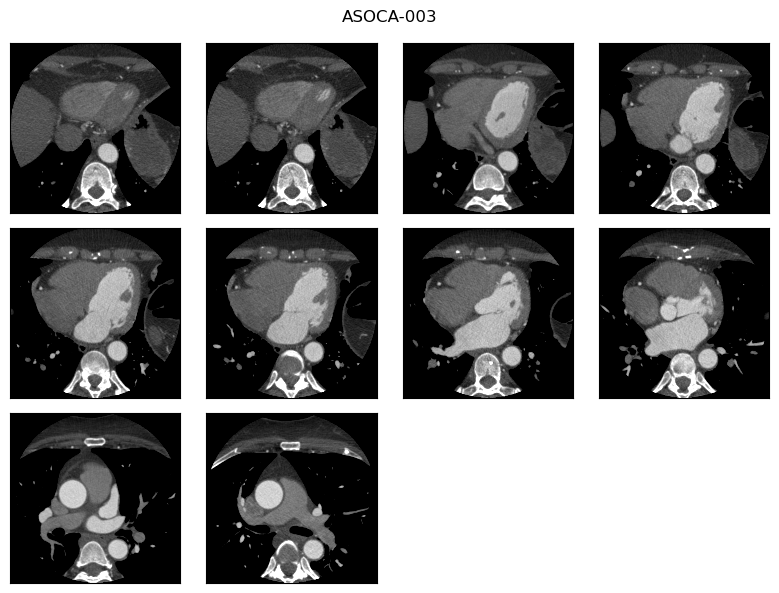

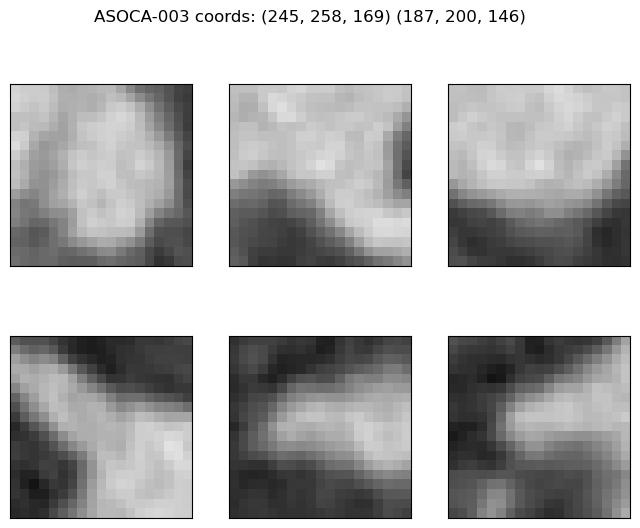

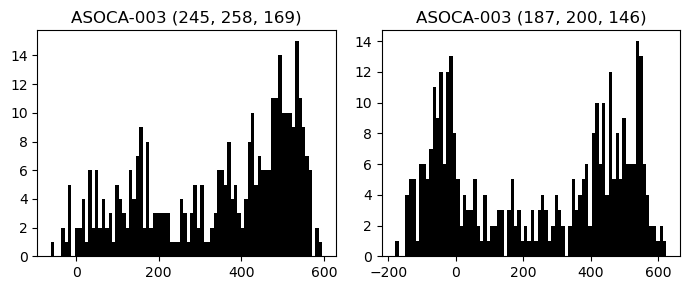

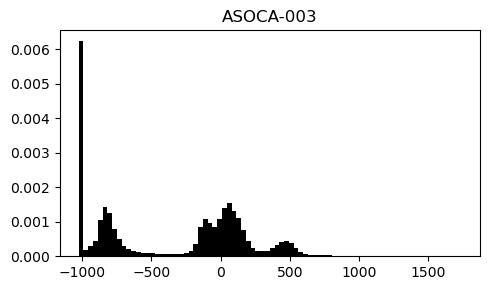

/home/marco/data/dataset_samples/ct_test_2002_image.h5


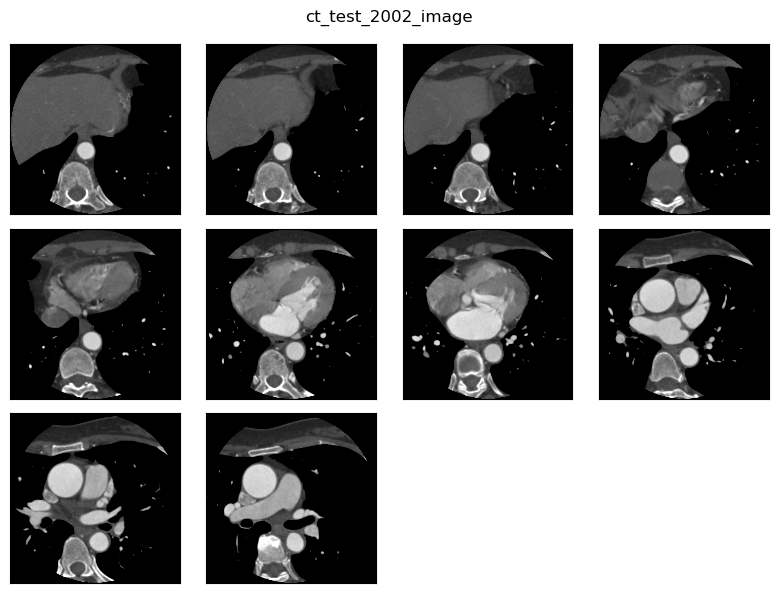

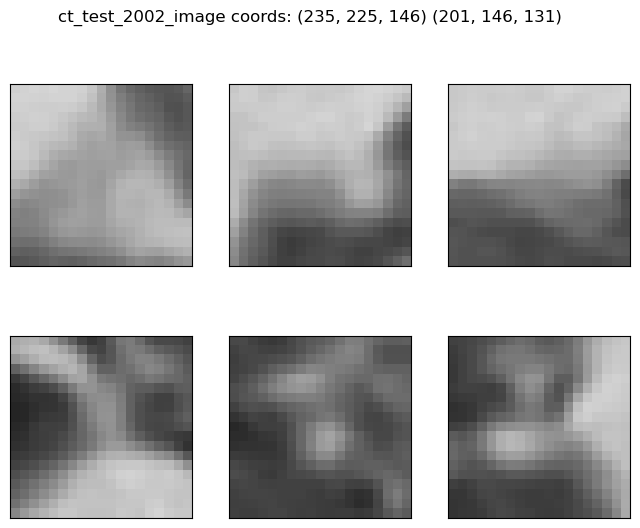

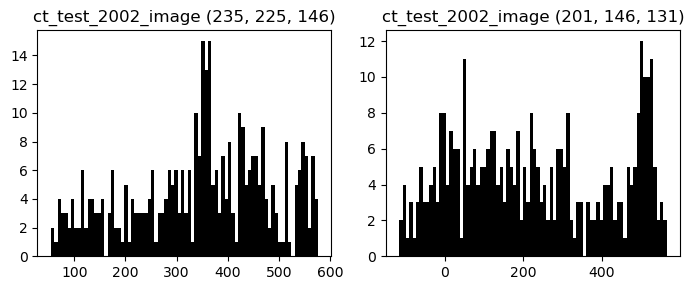

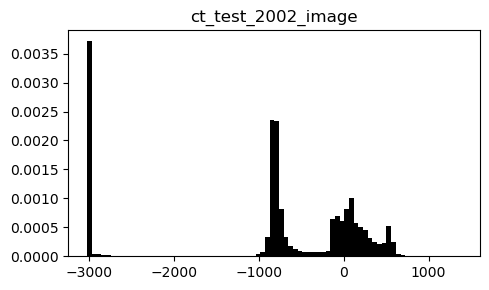

/home/marco/data/dataset_samples/ct_train_1005_image.h5


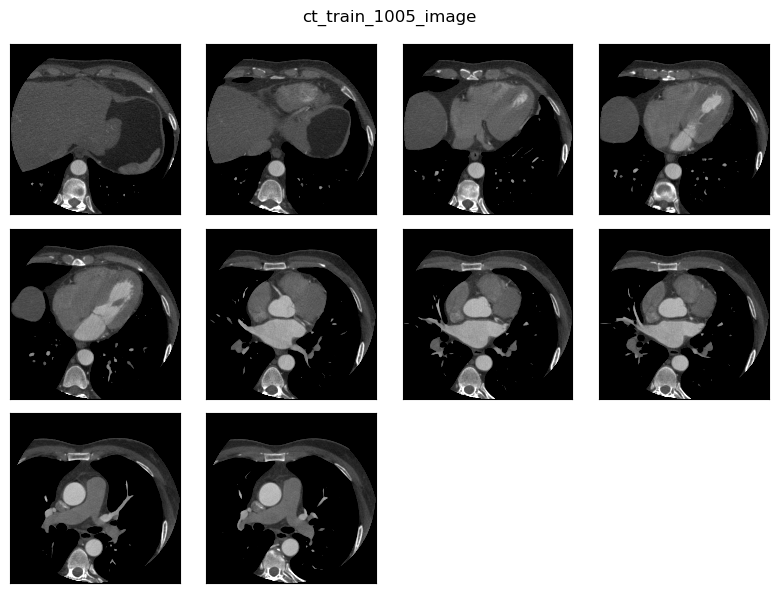

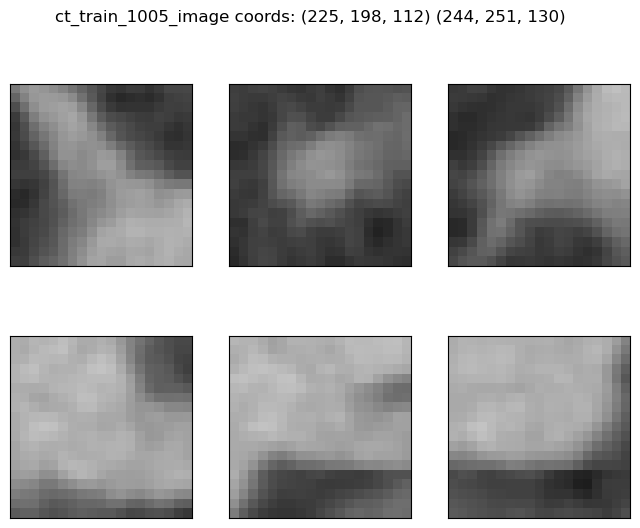

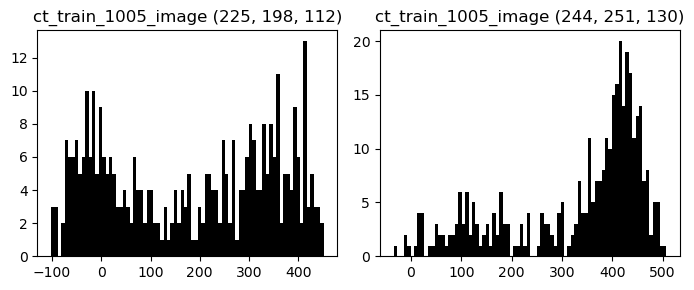

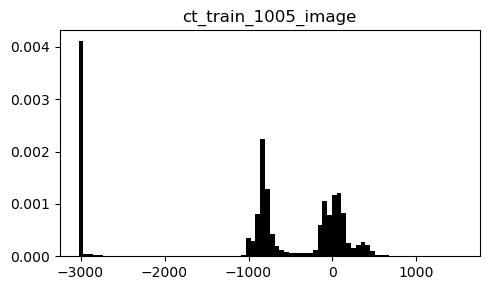

In [9]:
from matplotlib import pyplot as plt
import numpy as np

from contrast_gan_3D.constants import VMIN, VMAX
from contrast_gan_3D.utils import io_utils, visualization

rng = np.random.default_rng()

for s in samples:
    print(s)

    is_cadrads = "ASOCA" not in str(s) and "ct_" not in str(s)
    img, meta, f = io_utils.load_h5_image(s, is_cadrads=is_cadrads)

    title = io_utils.stem(s)

    ids = sorted(rng.choice(img.shape[-1], 10, replace=False))
    axes = visualization.plot_axial_slices(
        img[..., ids], title=title, figsize=(8, 6), vmin=VMIN, vmax=VMAX
    )
    plt.show()
    plt.close(axes[0, 0].get_figure())

    ostia_patches, ostia_world_coords = geometry.extract_ostia_patch_3D(
        img,
        meta,
        title,
        cadrads_df if is_cadrads else ostia_df,
        coords_prefix="ostium_" if is_cadrads else ""
    )
    ostia_img_coords = geometry.world_to_image_coords(
        ostia_world_coords, meta["offset"], meta["spacing"]
    )
    title_coords0, title_coords1 = list(map(tuple, ostia_img_coords))

    fig, axes = plt.subplots(2, 3, figsize=(8, 6))
    for ostium, axes_row in zip(ostia_patches, axes):
        axes = visualization.plot_ostium_patch(ostium, axes=axes_row)
    fig.suptitle(
        f"{title} coords: {title_coords0} {title_coords1}",
    )
    plt.show()
    plt.close(fig)

    z_middle = ostia_patches.shape[-1] // 2
    axes = visualization.plot_image_histogram(
        (ostia_patches[0, ..., z_middle], f"{title} {title_coords0}"),
        (ostia_patches[1, ..., z_middle], f"{title} {title_coords1}"),
        tight=True,
        figsize=(7, 3),
    )
    plt.show()
    plt.close(axes[0, 0].get_figure())

    axes = visualization.plot_image_histogram(
        (img[::], title), tight=True, figsize=(5, 3), density=True
    )
    plt.show()
    plt.close(axes[0, 0].get_figure())

    f.close()

---

### 2.3. Create a dataset of ostia mean HU values and standard deviation

In [11]:
from typing import Optional, Tuple, Dict, Union

from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import GridSearchCV


def GMM_grid_search(
    ostium_patch_1D: np.ndarray,
    max_n_components: int,
    max_iter: int = 1000,
    random_state: Optional[int] = None,
) -> GridSearchCV:
    return GridSearchCV(
        GMM(max_iter=max_iter, random_state=random_state, covariance_type="full"),
        param_grid={"n_components": range(1, max_n_components + 1)},
        scoring=lambda estimator, X: -estimator.bic(X),
    ).fit(ostium_patch_1D)


def pick_GMM_component(gmm: GMM) -> Tuple[Dict[str, float], pd.DataFrame]:
    mu, std = gmm.means_.squeeze(), np.sqrt(gmm.covariances_.squeeze())
    df = pd.DataFrame(
        np.stack([mu, std, gmm.weights_]).T, columns=["mu", "std", "weights"]
    ).sort_values(by="mu", ascending=False)
    return df.loc[df["std"] <= 150, df.columns != "weights"].iloc[0].to_dict(), df


def compute_ostia_HU_value(
    h5_scan_path: Union[Path, str],
    ostia_df: pd.DataFrame,
    savedir: Optional[Union[Path, str]],
    gmm_max_components: int,
    seed: Optional[int] = None,
    is_cadrads: bool = False,
    show: bool = True,
) -> Tuple[Dict[str, Union[float, str]], pd.DataFrame, np.ndarray]:
    if savedir is not None:
        savedir = Path(savedir)
        savedir.mkdir(parents=True, exist_ok=True)

    img, meta, f = io_utils.load_h5_image(h5_scan_path, is_cadrads=is_cadrads)
    name = io_utils.stem(h5_scan_path)
    # 1. Sample the ostia patches
    ostia_patches, ostia_world_coords = geometry.extract_ostia_patch_3D(
        img, meta, name, ostia_df, coords_prefix="ostium_" if is_cadrads else ""
    )
    f.close()
    res = []
    for ostium in ostia_patches.reshape(2, -1, 1):
        # 2. Fit a GMM with a hyperparams search on the flat patches' intensities
        grid_search = GMM_grid_search(ostium, gmm_max_components, random_state=seed)
        gmm = grid_search.best_estimator_
        print("Optimal # components:", gmm.n_components)
        # 3. Select the Gaussian component with reasonable std and highest mean HU values
        hu_peak, df = pick_GMM_component(gmm)
        res.append(({"ID": name} | hu_peak, df))
        print(res[-1][0])

    # *** Plotting ***
    ostia_img_coords = geometry.world_to_image_coords(
        ostia_world_coords, meta["offset"], meta["spacing"]
    )
    title_coords0, title_coords1 = list(map(tuple, ostia_img_coords))
    z_middle = ostia_patches.shape[-1] // 2

    fig, axes = plt.subplots(2, 5, figsize=(16, 6))
    visualization.plot_image_histogram(
        (ostia_patches[0, ..., z_middle], str(title_coords0)),
        (ostia_patches[1, ..., z_middle], str(title_coords1)),
        figsize=(6, 4),
        axes=axes[:, 0],
    )
    for ostium_patch, axes_row, (hu_peak, df) in zip(ostia_patches, axes, res):
        visualization.plot_gmm_fitted_ostium_patch(
            ostium_patch,
            *df.values.T[..., None],
            gmm_max_components,
            axes=axes_row[1:],
            title=f"mu: {hu_peak['mu']:.2f} std: {hu_peak['std']:.2f}",
        )
    fig.suptitle(f"{name}, columns 1-4: Z middle, 5: full 3D patch")
    plt.tight_layout()
    if savedir is not None:
        plt.savefig(savedir / f"{name}_ostia_HU.png")
    if show:
        plt.show()
    plt.close(fig)

    return *zip(*res), axes

Adjust the variables in the following cell to match your setup:

In [12]:
from itertools import chain

from contrast_gan_3D.config import DEFAULT_SEED

DATA_DIRS = [
    Path(f"/home/marco/data/{d}")
    for d in ["ASOCA_Philips/images", "MMWHS/ct_train", "MMWHS/ct_test"]
]

HU_DF_FNAME = Path("/home/marco/data/ostia_HU.xlsx")

PLOTS_SAVEDIR = "/home/marco/contrast-gan-3D/assets/ostia_HU_GMM/"

SEED = DEFAULT_SEED

GMM_N_MIXTURES = 6

SHOW, IS_CADRADS = False, "CADRADS" in str(DATA_DIRS)

DF = ostia_df if not IS_CADRADS else cadrads_df

scans = sorted(chain(*[list(d.glob("*.h5")) for d in DATA_DIRS]))

print(len(scans))
print(HU_DF_FNAME)
print(PLOTS_SAVEDIR)
print(GMM_N_MIXTURES)
print(SHOW, IS_CADRADS)
ostia_df

120
/home/marco/data/ostia_HU.xlsx
/home/marco/contrast-gan-3D/assets/ostia_HU_GMM/
6
False False


,ID,x,y,z,dataset
0,ASOCA-000,212,211,-103,ASOCA
1,ASOCA-000,219,240,-93,ASOCA
2,ASOCA-001,177,260,-95,ASOCA
3,ASOCA-001,189,287,-83,ASOCA
4,ASOCA-002,189,229,-110,ASOCA
...,...,...,...,...,...
235,ct_test_2038_image,14,214,-174,MMWHS
236,ct_test_2039_image,-4,110,-115,MMWHS
237,ct_test_2039_image,8,142,-105,MMWHS
238,ct_test_2040_image,16,303,-126,MMWHS


**The following cell might overwrite existing files!**

In [13]:
%%time

if HU_DF_FNAME.is_file():
    ostia_HU_df = pd.read_excel(HU_DF_FNAME)
    print("Loaded ostia HU mean and std")
else:
    ostia_HU_df = []
    for s in scans:
        print(s)
        hu_peaks, *_ = compute_ostia_HU_value(
            s,
            DF,
            PLOTS_SAVEDIR,
            GMM_N_MIXTURES,
            seed=SEED,
            show=SHOW,
            is_cadrads=IS_CADRADS,
        )
        print("---")
        ostia_HU_df += hu_peaks

    ostia_HU_df = pd.DataFrame(ostia_HU_df)
    ostia_HU_df.to_excel(HU_DF_FNAME, index=False)
    print(f"Saved HU dataframe to '{HU_DF_FNAME}'")

ostia_HU_df

Loaded ostia HU mean and std
CPU times: user 19 ms, sys: 0 ns, total: 19 ms
Wall time: 18.6 ms


,ID,mu,std
0,ASOCA-000,410.018109,40.386059
1,ASOCA-000,419.521842,38.595875
2,ASOCA-001,462.430047,41.042459
3,ASOCA-001,483.141373,29.186398
4,ASOCA-002,545.546054,29.719504
...,...,...,...
235,ct_train_1018_image,570.931610,106.051776
236,ct_train_1019_image,260.392678,39.093942
237,ct_train_1019_image,386.348995,35.238637
238,ct_train_1020_image,432.363825,120.648167


In [16]:
FULL_OSTIA_DATASET_PATH = Path("/home/marco/data/ostia.xlsx")

if not FULL_OSTIA_DATASET_PATH.is_file():
    full_df = pd.concat([ostia_df, ostia_HU_df], axis=1)
    full_df = full_df.loc[:, ~full_df.columns.duplicated()]
    full_df.to_excel(FULL_OSTIA_DATASET_PATH, index=False)
    print("Saved ostia coordinates and HU values dataset")
else:
    full_df = pd.read_excel(FULL_OSTIA_DATASET_PATH)
    print("Loaded ostia coordinates and HU values dataset")

full_df

Saved ostia coordinates and HU values dataset


,ID,x,y,z,dataset,mu,std
0,ASOCA-000,231,219,149,ASOCA,410.018109,40.386059
1,ASOCA-000,246,289,166,ASOCA,419.521842,38.595875
2,ASOCA-001,181,265,128,ASOCA,462.430047,41.042459
3,ASOCA-001,211,332,148,ASOCA,483.141373,29.186398
4,ASOCA-002,249,283,174,ASOCA,545.546054,29.719504
...,...,...,...,...,...,...,...
235,ct_test_2038_image,214,185,189,MMWHS,570.931610,106.051776
236,ct_test_2039_image,189,198,112,MMWHS,260.392678,39.093942
237,ct_test_2039_image,231,302,128,MMWHS,386.348995,35.238637
238,ct_test_2040_image,226,262,184,MMWHS,432.363825,120.648167


---

In [15]:
def label_ccta_scan(
    ostia_HU_df: pd.DataFrame, is_cadrads: bool = True, std_threshold: float = 500.0
) -> pd.DataFrame:
    ostia_hu_df = cadrads_df.iloc[
        cadrads_df.groupby("ID" if is_cadrads else "id").apply(
            lambda x: x["std"].idxmin()
        )
    ]
    if is_cadrads:
        ostia_hu_df = ostia_hu_df.drop_duplicates(subset=["mu", "std"])
    ostia_hu_df = ostia_hu_df[ostia_hu_df["std"] < std_threshold]
    # label the CT scans based on the mean HU intensity at the coronary aortic root
    ret = ostia_HU_df.copy()
    ret.loc[ret["mu"].between(300, 500), "label"] = 0
    ret.loc[ret["mu"] <= 300, "label"] = -1
    ret.loc[ret["mu"] >= 500, "label"] = 1
    ret["label"] = ret["label"].astype("int8")
    return ret

In [16]:
HU_df_labs = label_ccta_scan(ostia_HU_df)
display(HU_df_labs)

for lab in sorted(HU_df_labs["label"].unique()):
    print(
        f"Label {lab}: {len(HU_df_labs.loc[HU_df_labs['label'] == lab]) / len(HU_df_labs):.3f}"
    )

,ID,mu,std,label
0,ASOCA-000,410.018109,40.386059,0
1,ASOCA-000,419.521842,38.595875,0
2,ASOCA-001,462.430047,41.042459,0
3,ASOCA-001,483.141373,29.186398,0
4,ASOCA-002,545.546054,29.719504,1
...,...,...,...,...
235,ct_train_1018_image,570.931610,106.051776,1
236,ct_train_1019_image,260.392678,39.093942,-1
237,ct_train_1019_image,386.348995,35.238637,0
238,ct_train_1020_image,432.363825,120.648167,0


Label -1: 0.096
Label 0: 0.588
Label 1: 0.317


In [17]:
HU_df_cadrads_labs = label_ccta_scan(cadrads_df, is_cadrads=True)
display(HU_df_cadrads_labs)

for lab in sorted(HU_df_cadrads_labs["label"].unique()):
    print(
        f"Label {lab}: {len(HU_df_cadrads_labs.loc[HU_df_cadrads_labs['label'] == lab]) / len(HU_df_cadrads_labs):.3f}"
    )

,ID,ostium_x,ostium_y,ostium_z,mu,std,label
0,3085,23,-178,1252,573.105302,57.902959,1
1,3085,12,-200,1233,538.005343,87.082425,1
2,3086,4,-194,1237,523.857636,61.907001,1
3,3086,7,-166,1251,531.562540,52.082457,1
4,3088,10,-153,1157,631.225881,50.576542,1
...,...,...,...,...,...,...,...
2553,Contrast3077,18,-159,1298,446.098845,46.381451,0
2554,Contrast3079,-2,-185,1241,473.004120,52.669296,0
2555,Contrast3079,1,-157,1254,488.943719,44.068676,0
2556,Contrast3080,0,-182,1183,556.487432,46.865513,1


Label -1: 0.101
Label 0: 0.656
Label 1: 0.243
